# Libraries

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import joblib

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_recall_curve
from sklearn import preprocessing

import re
import nltk
from nltk.stem import WordNetLemmatizer #word stemmer class
lemma = WordNetLemmatizer()

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.utils import plot_model
from keras.models import Sequential
from keras.layers import Dense, Bidirectional, LSTM, Dropout, BatchNormalization
from keras.layers import Embedding
from keras.callbacks import EarlyStopping


from sklearn.pipeline import make_pipeline
from lime.lime_text import LimeTextExplainer

import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download('stopwords')



[nltk_data] Error loading stopwords: <urlopen error [Errno 8] nodename
[nltk_data]     nor servname provided, or not known>


False

# Glove word embeddings

In [ ]:
embeddings_index = dict()
f = open('/Users/bablo/Desktop/Mepco/Project/Final/glove.840B.300d.txt')
for line in f:
    values = line.split()
    word = values[0]
    try:
      coefs = np.asarray(values[1:], dtype='float32')
      embeddings_index[word] = coefs
    except ValueError:
      print ("error on line",line)
f.close()

file = open("embedding_data.pkl", "wb")
pickle.dump(embeddings_index, file)
file.close()

In [18]:
file = open("embedding_data.pkl", "rb")
embeddings_index = pickle.load(file)
file.close()

In [12]:
from nltk.corpus import stopwords
def preprocess_text(tweet):
    tweet = tweet.lower() # Convert to lowercase
    tweet = re.sub(r'[^\x00-\x7F]+',' ', tweet) # Remove words with non-ASCII characters
    words = tweet.split()
    words = filter(lambda x: x[0]!= '@' , tweet.split()) # Remove user tags
    words = [word for word in words if word not in set(stopwords.words('english'))] # Remove stop words
    tweet = " ".join(words)
    return tweet

# Load dataset

In [13]:
df_total = pd.read_csv('Dataset/Dataset.csv')
display(df_total.head())

text     label
0  ev battery technology tesla patent hints at mo...  non-hate
1  this company converts food byproducts into new...  non-hate
2  bom warns cape york could face another cyclone...  non-hate
3  relating terrorism with the poppy you are all ...  non-hate
4  from terrorism then they are surrounded by del...  non-hate

## Preprocessing

In [14]:
le = preprocessing.LabelEncoder()
le.fit(df_total.label)
df_total['label'] = le.transform(df_total.label)
display(df_total.head())

text  label
0  ev battery technology tesla patent hints at mo...      1
1  this company converts food byproducts into new...      1
2  bom warns cape york could face another cyclone...      1
3  relating terrorism with the poppy you are all ...      1
4  from terrorism then they are surrounded by del...      1

In [15]:
df_total['preprocessedTweet'] = df_total.text.apply(preprocess_text)
display(df_total.head())

text  label  \
0  ev battery technology tesla patent hints at mo...      1   
1  this company converts food byproducts into new...      1   
2  bom warns cape york could face another cyclone...      1   
3  relating terrorism with the poppy you are all ...      1   
4  from terrorism then they are surrounded by del...      1   

                                   preprocessedTweet  
0  ev battery technology tesla patent hints relia...  
1  company converts food byproducts new healthy food  
2  bom warns cape york could face another cyclone...  
3                     relating terrorism poppy laugh  
4  terrorism surrounded delays forgetfulness sinc...

In [16]:
df_total.isna().sum()

text                 0
label                0
preprocessedTweet    0
dtype: int64

In [19]:
max_length = df_total.preprocessedTweet.apply(lambda x: len(x.split())).max()

t = Tokenizer()
t.fit_on_texts(df_total.preprocessedTweet)
vocab_size = len(t.word_index) + 1
encoded_tweets = t.texts_to_sequences(df_total.preprocessedTweet)
padded_tweets = pad_sequences(encoded_tweets, maxlen=max_length, padding='post')


embedding_matrix = np.zeros((vocab_size, 300))
for word, i in t.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector



In [38]:
x_train, x_test, y_train, y_test = train_test_split(padded_tweets, df_total.label, test_size=0.2, stratify=df_total.label)

# Dataset Processing

In [4]:
df = pd.read_csv('/Users/bablo/Desktop/Project/Final/Dataset/Dataset.csv')
le = preprocessing.LabelEncoder()
le.fit(df.label)
df['label'] = le.transform(df.label)
display(df.head())

df['preprocessedTweet'] = df.text.apply(preprocess_text)
display(df.head())


text  label
0  ev battery technology tesla patent hints at mo...      1
1  this company converts food byproducts into new...      1
2  bom warns cape york could face another cyclone...      1
3  relating terrorism with the poppy you are all ...      1
4  from terrorism then they are surrounded by del...      1

text  label  \
0  ev battery technology tesla patent hints at mo...      1   
1  this company converts food byproducts into new...      1   
2  bom warns cape york could face another cyclone...      1   
3  relating terrorism with the poppy you are all ...      1   
4  from terrorism then they are surrounded by del...      1   

                                   preprocessedTweet  
0  ev battery technology tesla patent hints relia...  
1  company converts food byproducts new healthy food  
2  bom warns cape york could face another cyclone...  
3                     relating terrorism poppy laugh  
4  terrorism surrounded delays forgetfulness sinc...

In [8]:
df.to_csv("Preprocessed Dataset/dataset.csv")

In [39]:
df = pd.read_csv("Preprocessed Dataset/dataset.csv")

In [40]:
max_length = df.preprocessedTweet.apply(lambda x: len(x.split())).max()

t = Tokenizer()
t.fit_on_texts(df.preprocessedTweet)
vocab_size = len(t.word_index) + 1
encoded_tweets = t.texts_to_sequences(df.preprocessedTweet)
padded_tweets = pad_sequences(encoded_tweets, maxlen=max_length, padding='post')

embedding_matrix = np.zeros((vocab_size, 300))
for word, i in t.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector


AttributeError: 'float' object has no attribute 'split'

In [41]:
print(t)

In [6]:
x_train, x_test, y_train, y_test = train_test_split(padded_tweets, df.label, test_size=0.2, stratify=df.label)

In [7]:
y_train_categorical = to_categorical(y_train)
y_test_categorical = to_categorical(y_test)

# Dataset Train Test Val

In [17]:
df_train= pd.read_csv('Dataset/Training Dataset.csv')

le = preprocessing.LabelEncoder()
le.fit(df_train.label)
df_train['label'] = le.transform(df_train.label)
display(df_train.head())

df_train['preprocessedTweet'] = df_train.text.apply(preprocess_text)
display(df_train.head())


text  label
0  ev battery technology tesla patent hints at mo...      1
1  this company converts food byproducts into new...      1
2  bom warns cape york could face another cyclone...      1
3  relating terrorism with the poppy you are all ...      1
4  from terrorism then they are surrounded by del...      1

text  label  \
0  ev battery technology tesla patent hints at mo...      1   
1  this company converts food byproducts into new...      1   
2  bom warns cape york could face another cyclone...      1   
3  relating terrorism with the poppy you are all ...      1   
4  from terrorism then they are surrounded by del...      1   

                                   preprocessedTweet  
0  ev battery technology tesla patent hints relia...  
1  company converts food byproducts new healthy food  
2  bom warns cape york could face another cyclone...  
3                     relating terrorism poppy laugh  
4  terrorism surrounded delays forgetfulness sinc...

In [18]:
df_train.to_csv("Preprocessed Dataset/train.csv")

In [19]:
max_length_train =df_train.preprocessedTweet.apply(lambda x: len(x.split())).max()

t = Tokenizer()
t.fit_on_texts(df_train.preprocessedTweet)
encoded_tweets = t.texts_to_sequences(df_train.preprocessedTweet)
padded_tweets_train = pad_sequences(encoded_tweets, maxlen=max_length, padding='post')

print(max_length_train)


62


In [20]:
x_train=padded_tweets_train
y_train = to_categorical(df_train['label'])

In [21]:
df_test= pd.read_csv('Dataset/Testing Dataset.csv')

le = preprocessing.LabelEncoder()
le.fit(df_test.label)
df_test['label'] = le.transform(df_test.label)
display(df_test.head())

df_test['preprocessedTweet'] = df_test.text.apply(preprocess_text)
display(df_test.head())


text  label
0  watch out as unwinds in india would nt be surp...      1
1  cyber security predictions 2019 watch for thes...      1
2  is hiring applications welcome from those work...      1
3  catch up on ces 2019 and more at globalmedia i...      1
4  held syria responsible for using chemical weap...      1

text  label  \
0  watch out as unwinds in india would nt be surp...      1   
1  cyber security predictions 2019 watch for thes...      1   
2  is hiring applications welcome from those work...      1   
3  catch up on ces 2019 and more at globalmedia i...      1   
4  held syria responsible for using chemical weap...      1   

                                   preprocessedTweet  
0  watch unwinds india would nt surprised turns h...  
1  cyber security predictions 2019 watch four imp...  
2  hiring applications welcome working critically...  
3                catch ces 2019 globalmedia magazine  
4  held syria responsible using chemical weapons ...

In [22]:
df_test.to_csv("Preprocessed Dataset/test.csv")

In [23]:
max_length_test = df_test.preprocessedTweet.apply(lambda x: len(x.split())).max()

t = Tokenizer()
t.fit_on_texts(df_test.preprocessedTweet)
encoded_tweets = t.texts_to_sequences(df_test.preprocessedTweet)
padded_tweets_test = pad_sequences(encoded_tweets, maxlen=max_length, padding='post')

print(max_length_test)

57


In [24]:
x_test=padded_tweets_test
y_test = to_categorical(df_test['label'])

In [25]:
df_val= pd.read_csv('Dataset/Validation Dataset.csv')

le = preprocessing.LabelEncoder()
le.fit(df_val.label)
df_val['label'] = le.transform(df_val.label)
display(df_val.head())

df_val['preprocessedTweet'] = df_val.text.apply(preprocess_text)
display(df_val.head())

text  label
0  no it dosent but its born out of frustration c...      1
1  oh these are savarnas for whom anti casteism i...      1
2  speech of gh nabi azad on jammu kashmir situat...      1
3     now that is better 4 29 million not bad at all      1
4  stuff i could happily never see again in crime...      1

text  label  \
0  no it dosent but its born out of frustration c...      1   
1  oh these are savarnas for whom anti casteism i...      1   
2  speech of gh nabi azad on jammu kashmir situat...      1   
3     now that is better 4 29 million not bad at all      1   
4  stuff i could happily never see again in crime...      1   

                                   preprocessedTweet  
0    dosent born frustration crime levels soaring ev  
1         oh savarnas anti casteism obvious anything  
2  speech gh nabi azad jammu kashmir situation pa...  
3                            better 4 29 million bad  
4        stuff could happily never see crime fiction

In [26]:
df_val.to_csv("Preprocessed Dataset/val.csv")

In [27]:
max_length_val = df_val.preprocessedTweet.apply(lambda x: len(x.split())).max()

t = Tokenizer()
t.fit_on_texts(df_val.preprocessedTweet)
encoded_tweets = t.texts_to_sequences(df_val.preprocessedTweet)
padded_tweets_val = pad_sequences(encoded_tweets, maxlen=max_length, padding='post')


print(max_length_val)

292


In [28]:
x_val=padded_tweets_val
y_val = to_categorical(df_val['label'])

In [29]:
print(max_length)

292


# CNN

In [42]:
from keras.models import Model
from keras.layers import Input, Embedding, Conv1D, MaxPooling1D, Flatten, Dense, Concatenate, Attention

In [43]:
# Model architecture
input_length = max_length
embedding_dim = 50
num_filters = 150
filter_sizes = [2, 3, 4]
pool_size = 2
dense_units = 100
output_classes = 2  # 2 classes: hate speech and non-hate speech
attention_units = 100
dropout_rate = 0.25

In [94]:
input_layer = Input(shape=(input_length,))

In [95]:

# Embedding layer
embedding_dim = 300  # Set the size of the embedding dimension
embedding_layer = Embedding(vocab_size, 300, input_length=max_length, weights=[embedding_matrix], trainable=True)(input_layer)


In [96]:
# Convolutional layers
conv_layers = []
for filter_size in filter_sizes:
    conv = Conv1D(filters=num_filters, kernel_size=filter_size, activation='relu',padding='same')(embedding_layer)
    pooled = MaxPooling1D(pool_size=pool_size)(conv)
    conv_layers.append(pooled)


In [97]:
merged = Concatenate(axis=-1)(conv_layers)

# Attention layer
attention = Attention(use_scale=True, causal=True)([merged, merged])
attention = Dropout(rate=dropout_rate)(attention)

# Flatten the attention output
flattened = Flatten()(attention)

# Dense layers
dense1 = Dense(units=dense_units, activation='relu')(flattened)
dense1 = Dropout(rate=dropout_rate)(dense1)

dense2 = Dense(units=dense_units, activation='relu')(dense1)
dense2 = Dropout(rate=dropout_rate)(dense2)

# Output layer
output_layer = Dense(units=output_classes, activation='softmax')(dense2)

# Create the model
cnnmodel = Model(inputs=input_layer, outputs=output_layer)

# Compile the model with an appropriate optimizer, loss, and metrics
cnnmodel.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display the model summary
cnnmodel.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_11 (InputLayer)       [(None, 292)]                0         []                            
                                                                                                  
 embedding_5 (Embedding)     (None, 292, 300)             6746100   ['input_11[0][0]']            
                                                                                                  
 conv1d_6 (Conv1D)           (None, 292, 150)             90150     ['embedding_5[0][0]']         
                                                                                                  
 conv1d_7 (Conv1D)           (None, 292, 150)             135150    ['embedding_5[0][0]']         
                                                                                            

In [98]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler, ReduceLROnPlateau, TerminateOnNaN

callback_list = [
                 ModelCheckpoint(
                     filepath = './best_CNNmodel.hdf5',
                     monitor = 'val_accuracy',
                     verbose = 1,
                     save_best_only = True,
                     save_weights_only = False,
                     mode = 'max',
                     period = 1
                 ),

                 EarlyStopping(
                    monitor = 'val_accuracy',
                    patience = 20,
                    verbose = 1,
                    mode = 'max',
                    baseline = 0.5,
                    restore_best_weights = True
                 ),

                 ReduceLROnPlateau(
                     monitor = 'val_loss',
                     factor = 0.2,
                     patience = 5,
                     verbose = 1,
                     mode = 'min',
                     cooldown = 1,
                     min_lr = 0
                 ),

                 TerminateOnNaN()
]

In [100]:
history = cnnmodel.fit(x_train,y_train_categorical, epochs=20, batch_size=64,verbose = 1,callbacks = callback_list,validation_split = 0.02,shuffle = True)

Epoch 1/20
126/126 [==============================] - ETA: 0s - loss: 0.0166 - accuracy: 0.9970
Epoch 1: val_accuracy did not improve from 0.83537
126/126 [==============================] - 75s 592ms/step - loss: 0.0166 - accuracy: 0.9970 - val_loss: 1.3406 - val_accuracy: 0.8110 - lr: 0.0010
Epoch 2/20
126/126 [==============================] - ETA: 0s - loss: 0.0050 - accuracy: 0.9986
Epoch 2: val_accuracy did not improve from 0.83537
126/126 [==============================] - 76s 604ms/step - loss: 0.0050 - accuracy: 0.9986 - val_loss: 1.5589 - val_accuracy: 0.8232 - lr: 0.0010
Epoch 3/20
126/126 [==============================] - ETA: 0s - loss: 0.0095 - accuracy: 0.9971
Epoch 3: val_accuracy improved from 0.83537 to 0.84756, saving model to ./best_CNNmodel.hdf5
126/126 [==============================] - 74s 585ms/step - loss: 0.0095 - accuracy: 0.9971 - val_loss: 1.3936 - val_accuracy: 0.8476 - lr: 0.0010
Epoch 4/20
126/126 [==============================] - ETA: 0s - loss: 0.0137

In [101]:
print("Best Validation Accuracy =", max(history.history['val_accuracy'])*100)
print("Best Training Accuracy =", max(history.history['accuracy'])*100)

Best Validation Accuracy = 84.75610017776489
Best Training Accuracy = 99.98754262924194


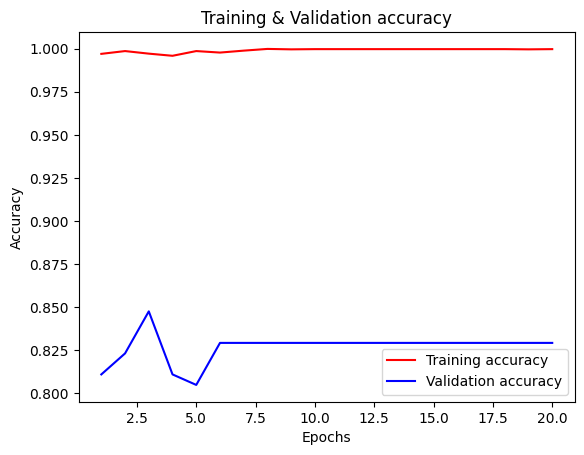

In [102]:
import matplotlib.pyplot as plt

train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = range(1, len(train_acc) + 1)

plt.plot(epochs, train_acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training & Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

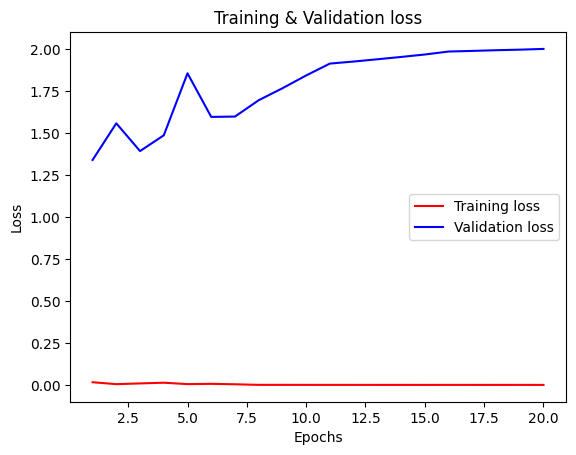

In [103]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(epochs, train_loss, 'r', label="Training loss")
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training & Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [104]:
test_metrics = cnnmodel.evaluate(x_test, y_test_categorical)

65/65 [==============================] - 8s 123ms/step - loss: 1.3998 - accuracy: 0.8521


In [105]:
test_accuracy = test_metrics[1]
test_loss = test_metrics[0]

print("Test Accuracy :", test_accuracy)
print("Test Accuracy :", test_loss)

Test Accuracy : 0.852122962474823
Test Accuracy : 1.3998037576675415


In [106]:
import numpy as np
from sklearn.metrics import confusion_matrix

# Assuming you have your test data in X_test and your true labels in y_test
# and that your model is already trained and saved as 'model'

# Generate predicted values using the model
y_pred = cnnmodel.predict(x_test)

# Convert predicted values to binary 0/1 predictions
y_pred = np.round(y_pred)



65/65 [==============================] - 9s 129ms/step


In [107]:
# Generate confusion matrix
cm=confusion_matrix(y_test_categorical.argmax(axis=1), y_pred.argmax(axis=1))

print(cm)

[[868 157]
 [146 878]]


In [108]:
print(classification_report(y_pred, y_test_categorical))

              precision    recall  f1-score   support

           0       0.85      0.86      0.85      1014
           1       0.86      0.85      0.85      1035

   micro avg       0.85      0.85      0.85      2049
   macro avg       0.85      0.85      0.85      2049
weighted avg       0.85      0.85      0.85      2049
 samples avg       0.85      0.85      0.85      2049



## Explainable AI

In [64]:
import tensorflow as tf

In [140]:
# Sample text for LIME analysis
sample_text = "I love this product!"

sample_sequence = t.texts_to_sequences([sample_text])
padded_sequence = pad_sequences(sample_sequence, maxlen=max_length,padding="post")



In [212]:
def pre(text):

    sample_sequence = t.texts_to_sequences(text)
    padded_sequence = pad_sequences(sample_sequence, maxlen=max_length,padding="post")
    y=cnnmodel.predict(padded_sequence)
    return y

    

In [234]:
# Sample text for LIME analysis
sample_text = "Gandhi said RSS is the biggest threat to India, still is"

In [235]:
class_names = ['negative', 'positive']
explainer = LimeTextExplainer(class_names=class_names)
exp = explainer.explain_instance(sample_text,pre)


157/157 [==============================] - 21s 137ms/step


In [236]:
exp.show_in_notebook(text=True)

## Threshold Effect: 
The validation accuracy remains stable even as the validation loss increases due to the outliers or noisy datapoints. They don't affect the overall accuracy.

In [25]:
cnnmodel.save("cnn.h5")
cnnmodel.save('cnn.keras')

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


save the model

In [24]:
cnnmodel.save("cnn.h5")
cnnmodel.save('cnn.keras')
model_filename = 'cnn.joblib'
joblib.dump(cnnmodel, model_filename)
print(f"Model saved to {model_filename}")

Model saved to cnn.joblib


# GRU

In [32]:
from keras.models import Sequential
from keras.layers import Embedding, Layer,Concatenate,Bidirectional, GRU, Dense,MultiHeadAttention,Flatten
import keras.backend as K


In [36]:
class AttentionLayer(Layer):
    def __init__(self, units=100, **kwargs):
        self.units = units
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W_q = self.add_weight(name="W_q", shape=(input_shape[-1], self.units), initializer="glorot_uniform", trainable=True)
        self.W_k = self.add_weight(name="W_k", shape=(input_shape[-1], self.units), initializer="glorot_uniform", trainable=True)
        super(AttentionLayer, self).build(input_shape)

    def call(self, x):
        q = K.dot(x, self.W_q)
        k = K.dot(x, self.W_k)
        v = x

        attention_scores = K.softmax(K.batch_dot(q, k, axes=[2, 2]) / K.sqrt(K.cast(self.units, dtype=K.floatx())), axis=-1)
        output = K.batch_dot(attention_scores, v, axes=[2, 1])
        return output

    def compute_output_shape(self, input_shape):
        return input_shape


In [13]:
# Define the model
grumodel = Sequential()

# Embedding layer
# Assuming vocab_size is the size of your vocabulary and embedding_dim is the dimension of your word embeddings
grumodel.add(Embedding(vocab_size, 300, input_length=max_length))


# Bidirectional GRU layer with 256 neurons
grumodel.add(Bidirectional(GRU(256, return_sequences=True)))

# GRU layer with 128 neurons
grumodel.add(GRU(128, return_sequences=True))

# Attention layer with 100 units
grumodel.add(AttentionLayer(units=100))

# Dropout layer after Attention layer
grumodel.add(Dropout(0.25))

grumodel.add(Flatten())

# Two dense layers with 100 neurons and ReLU activation
grumodel.add(Dense(100, activation='relu'))

# Dropout layer after the first Dense layer
grumodel.add(Dropout(0.25))

grumodel.add(Dense(100, activation='relu'))

# Dropout layer after the second Dense layer
grumodel.add(Dropout(0.25))

# Output layer with softmax activation
# Assuming num_classes is the number of classes in your classification task
grumodel.add(Dense(2, activation='softmax'))

# Compile the model with class weights
grumodel.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
grumodel.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 292, 300)          6746100   
                                                                 
 bidirectional_1 (Bidirecti  (None, 292, 512)          857088    
 onal)                                                           
                                                                 
 gru_3 (GRU)                 (None, 292, 128)          246528    
                                                                 
 attention_layer_1 (Attenti  (None, 292, 128)          25600     
 onLayer)                                                        
                                                                 
 dropout_1 (Dropout)         (None, 292, 128)          0         
                                                                 
 flatten (Flatten)           (None, 37376)            

In [14]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler, ReduceLROnPlateau, TerminateOnNaN

callback_list = [
                 ModelCheckpoint(
                     filepath = './best_GRUmodel.hdf5',
                     monitor = 'val_accuracy',
                     verbose = 1,
                     save_best_only = True,
                     save_weights_only = False,
                     mode = 'max',
                     period = 1
                 ),

                 EarlyStopping(
                    monitor = 'val_accuracy',
                    patience = 20,
                    verbose = 1,
                    mode = 'max',
                    baseline = 0.5,
                    restore_best_weights = True
                 ),

                 ReduceLROnPlateau(
                     monitor = 'val_loss',
                     factor = 0.2,
                     patience = 5,
                     verbose = 1,
                     mode = 'min',
                     cooldown = 1,
                     min_lr = 0
                 ),

                 TerminateOnNaN()
]

In [15]:
history = grumodel.fit(x_train,y_train_categorical, epochs=20, batch_size=64,verbose = 1,callbacks = callback_list,validation_split = 0.2,shuffle = True)

Epoch 1/20
103/103 [==============================] - ETA: 0s - loss: 0.7210 - accuracy: 0.4936
Epoch 1: val_accuracy improved from -inf to 0.49786, saving model to ./best_GRUmodel.hdf5


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


103/103 [==============================] - 225s 2s/step - loss: 0.7210 - accuracy: 0.4936 - val_loss: 0.6973 - val_accuracy: 0.4979 - lr: 0.0010
Epoch 2/20
103/103 [==============================] - ETA: 0s - loss: 0.5797 - accuracy: 0.6666
Epoch 2: val_accuracy improved from 0.49786 to 0.81269, saving model to ./best_GRUmodel.hdf5
103/103 [==============================] - 242s 2s/step - loss: 0.5797 - accuracy: 0.6666 - val_loss: 0.4002 - val_accuracy: 0.8127 - lr: 0.0010
Epoch 3/20
103/103 [==============================] - ETA: 0s - loss: 0.2779 - accuracy: 0.8908
Epoch 3: val_accuracy improved from 0.81269 to 0.84686, saving model to ./best_GRUmodel.hdf5
103/103 [==============================] - 210s 2s/step - loss: 0.2779 - accuracy: 0.8908 - val_loss: 0.3803 - val_accuracy: 0.8469 - lr: 0.0010
Epoch 4/20
103/103 [==============================] - ETA: 0s - loss: 0.1275 - accuracy: 0.9561
Epoch 4: val_accuracy did not improve from 0.84686
103/103 [==============================]

In [16]:
print("Best Validation Accuracy =", max(history.history['val_accuracy'])*100)
print("Best Training Accuracy =", max(history.history['accuracy'])*100)

Best Validation Accuracy = 84.68578457832336
Best Training Accuracy = 99.84742403030396


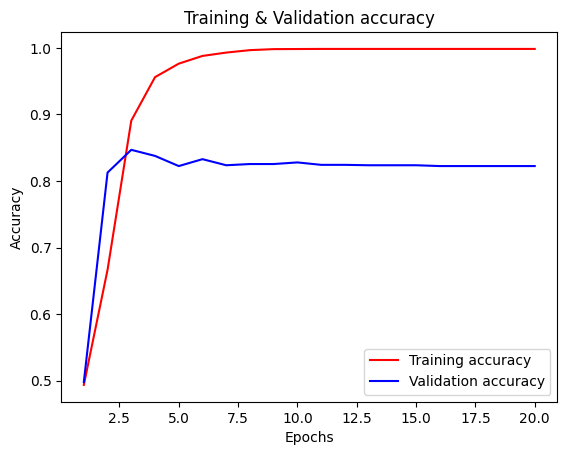

In [18]:
import matplotlib.pyplot as plt

train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = range(1, len(train_acc) + 1)

plt.plot(epochs, train_acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training & Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

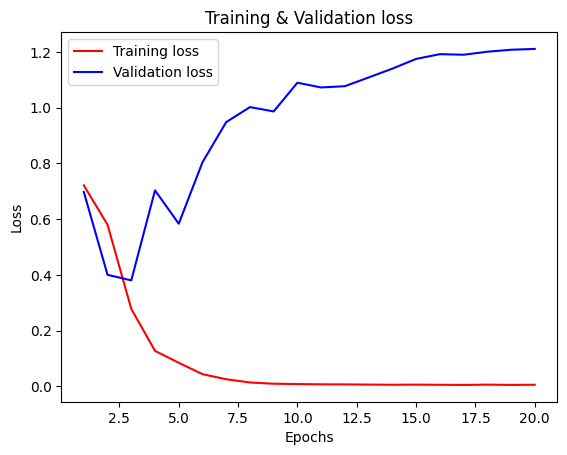

In [19]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(epochs, train_loss, 'r', label="Training loss")
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training & Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [21]:
test_metrics = grumodel.evaluate(x_test, y_test_categorical)

test_accuracy = test_metrics[1]
test_loss = test_metrics[0]

print("Test Accuracy :", test_accuracy)
print("Test Accuracy :", test_loss)

65/65 [==============================] - 32s 497ms/step - loss: 1.2520 - accuracy: 0.8150
Test Accuracy : 0.8150317072868347
Test Accuracy : 1.2520421743392944


In [23]:
import numpy as np
from sklearn.metrics import confusion_matrix

# Assuming you have your test data in X_test and your true labels in y_test
# and that your model is already trained and saved as 'model'

# Generate predicted values using the model
y_pred = grumodel.predict(x_test)

# Convert predicted values to binary 0/1 predictions
y_pred = np.round(y_pred)

65/65 [==============================] - 37s 565ms/step


In [24]:
# Generate confusion matrix
cm=confusion_matrix(y_test_categorical.argmax(axis=1), y_pred.argmax(axis=1))

print(cm)

[[826 199]
 [180 844]]


In [25]:
print(classification_report(y_pred, y_test_categorical))

              precision    recall  f1-score   support

           0       0.81      0.82      0.81      1006
           1       0.82      0.81      0.82      1043

   micro avg       0.82      0.82      0.82      2049
   macro avg       0.82      0.82      0.82      2049
weighted avg       0.82      0.82      0.82      2049
 samples avg       0.82      0.82      0.82      2049



In [29]:
history = grumodel.fit(x_train, y_train_categorical, epochs=20, batch_size=64,  validation_split=0.2)

Epoch 1/20


103/103 [==============================] - 189s 2s/step - loss: 0.7300 - accuracy: 0.4977 - val_loss: 0.6912 - val_accuracy: 0.5070
Epoch 2/20
103/103 [==============================] - 186s 2s/step - loss: 0.6136 - accuracy: 0.6454 - val_loss: 0.4295 - val_accuracy: 0.7907
Epoch 3/20
103/103 [==============================] - 198s 2s/step - loss: 0.3043 - accuracy: 0.8740 - val_loss: 0.3801 - val_accuracy: 0.8286
Epoch 4/20
103/103 [==============================] - 217s 2s/step - loss: 0.1557 - accuracy: 0.9452 - val_loss: 0.4819 - val_accuracy: 0.8231
Epoch 5/20
103/103 [==============================] - 194s 2s/step - loss: 0.0651 - accuracy: 0.9799 - val_loss: 0.6146 - val_accuracy: 0.8243
Epoch 6/20
103/103 [==============================] - 193s 2s/step - loss: 0.0342 - accuracy: 0.9895 - val_loss: 0.7197 - val_accuracy: 0.8328
Epoch 7/20
103/103 [==============================] - 197s 2s/step - loss: 0.0184 - accuracy: 0.9953 - val_loss: 1.1330 - val_accuracy: 0.8212
Epoch 8/20

In [31]:
loss, accuracy = grumodel.evaluate(x_test, y_test_categorical)


# Print the evaluation results
print(f'Test Loss: {loss:.4f}')
print(f'Test Accuracy: {accuracy*100:.2f}%')


65/65 [==============================] - 27s 409ms/step - loss: 1.2611 - accuracy: 0.8219
Test Loss: 1.2611
Test Accuracy: 82.19%


In [42]:
grumodel.save("gru.h5")
grumodel.save('gru.keras')
model_filename = 'gru.joblib'
joblib.dump(grumodel, model_filename)
print(f"Model saved to {model_filename}")

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model saved to gru.joblib


# LSTM

In [26]:
from keras.models import Model
from keras.layers import Input, Bidirectional, LSTM, Attention, Dense, Concatenate,Flatten

In [27]:

# Input layer
input_layer = Input(shape=(max_length,))  # Assuming sequence_length is predefined

# Embedding layer
embedding_layer = Embedding(vocab_size,300,input_length=max_length)(input_layer)

# B
# Bidirectional LSTM layer with 256 neurons
bi_lstm = Bidirectional(LSTM(256, return_sequences=True))(embedding_layer)

# LSTM layer with 128 neurons
lstm = LSTM(128, return_sequences=True)(bi_lstm)

# Attention layer
attention = Attention()([lstm, lstm])

# Concatenate the output of attention with the original LSTM output
attended_output = Concatenate(axis=-1)([lstm, attention])

# attended_output = Dropout(0.25)(attended_output)

flattened = Flatten()(attended_output)

# Two dense layers with ReLU activation
dense1 = Dense(100, activation='relu')(flattened)
dense2 = Dense(100, activation='relu')(dense1)

# dense2_with_dropout = Dropout(0.25)(dense2)

# Final output layer with softmax activation
output_layer = Dense(2, activation='softmax')(dense2)

# Create the model
lstmmodel = Model(inputs=input_layer, outputs=output_layer)

# Compile the model with an appropriate optimizer, loss, and metrics
lstmmodel.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display the model summary
lstmmodel.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 292)]                0         []                            
                                                                                                  
 embedding_2 (Embedding)     (None, 292, 300)             6746100   ['input_1[0][0]']             
                                                                                                  
 bidirectional_2 (Bidirecti  (None, 292, 512)             1140736   ['embedding_2[0][0]']         
 onal)                                                                                            
                                                                                                  
 lstm_1 (LSTM)               (None, 292, 128)             328192    ['bidirectional_2[0][0]'] 

In [28]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler, ReduceLROnPlateau, TerminateOnNaN

callback_list = [
                 ModelCheckpoint(
                     filepath = './best_LSTMmodel.hdf5',
                     monitor = 'val_accuracy',
                     verbose = 1,
                     save_best_only = True,
                     save_weights_only = False,
                     mode = 'max',
                     period = 1
                 ),

                 EarlyStopping(
                    monitor = 'val_accuracy',
                    patience = 20,
                    verbose = 1,
                    mode = 'max',
                    baseline = 0.5,
                    restore_best_weights = True
                 ),

                 ReduceLROnPlateau(
                     monitor = 'val_loss',
                     factor = 0.2,
                     patience = 5,
                     verbose = 1,
                     mode = 'min',
                     cooldown = 1,
                     min_lr = 0
                 ),

                 TerminateOnNaN()
]

In [30]:
history = lstmmodel.fit(x_train,y_train_categorical, epochs=20, batch_size=64,verbose = 1,callbacks = callback_list,validation_split = 0.02,shuffle = True)

Epoch 1/20
126/126 [==============================] - ETA: 0s - loss: 0.0186 - accuracy: 0.9959
Epoch 1: val_accuracy improved from 0.79878 to 0.82317, saving model to ./best_LSTMmodel.hdf5
126/126 [==============================] - 267s 2s/step - loss: 0.0186 - accuracy: 0.9959 - val_loss: 0.9902 - val_accuracy: 0.8232 - lr: 0.0010
Epoch 2/20
126/126 [==============================] - ETA: 0s - loss: 0.0122 - accuracy: 0.9964
Epoch 2: val_accuracy improved from 0.82317 to 0.83537, saving model to ./best_LSTMmodel.hdf5
126/126 [==============================] - 271s 2s/step - loss: 0.0122 - accuracy: 0.9964 - val_loss: 1.1221 - val_accuracy: 0.8354 - lr: 0.0010
Epoch 3/20
126/126 [==============================] - ETA: 0s - loss: 0.0053 - accuracy: 0.9988
Epoch 3: val_accuracy did not improve from 0.83537
126/126 [==============================] - 256s 2s/step - loss: 0.0053 - accuracy: 0.9988 - val_loss: 1.2284 - val_accuracy: 0.8354 - lr: 0.0010
Epoch 4/20
126/126 [==================

In [31]:
print("Best Validation Accuracy =", max(history.history['val_accuracy'])*100)
print("Best Training Accuracy =", max(history.history['accuracy'])*100)

Best Validation Accuracy = 84.14633870124817
Best Training Accuracy = 99.96263384819031


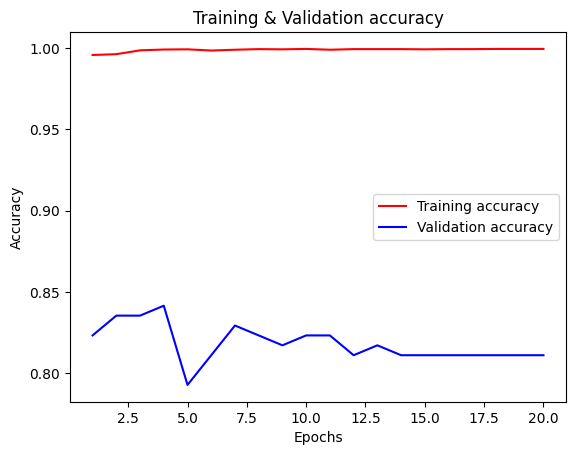

In [32]:
import matplotlib.pyplot as plt

train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = range(1, len(train_acc) + 1)

plt.plot(epochs, train_acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training & Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


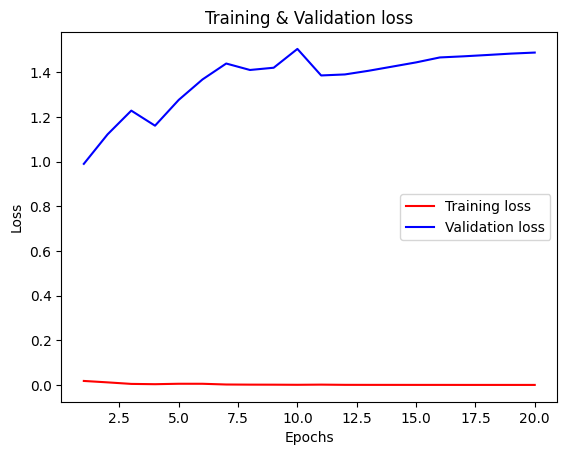

In [33]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(epochs, train_loss, 'r', label="Training loss")
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training & Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [34]:
test_metrics = lstmmodel.evaluate(x_test, y_test_categorical)

test_accuracy = test_metrics[1]
test_loss = test_metrics[0]

print("Test Accuracy :", test_accuracy)
print("Test Accuracy :", test_loss)

65/65 [==============================] - 39s 602ms/step - loss: 1.2940 - accuracy: 0.8184
Test Accuracy : 0.818448007106781
Test Accuracy : 1.2940318584442139


In [37]:
import numpy as np
from sklearn.metrics import confusion_matrix

# Assuming you have your test data in X_test and your true labels in y_test
# and that your model is already trained and saved as 'model'

# Generate predicted values using the model
y_pred = lstmmodel.predict(x_test)

# Convert predicted values to binary 0/1 predictions
y_pred = np.round(y_pred)

W0000 00:00:1707238626.331284       1 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" model: "0" frequency: 2400 num_cores: 8 environment { key: "cpu_instruction_set" value: "ARM NEON" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 16384 l2_cache_size: 524288 l3_cache_size: 524288 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


65/65 [==============================] - 38s 573ms/step


In [38]:
# Generate confusion matrix
cm=confusion_matrix(y_test_categorical.argmax(axis=1), y_pred.argmax(axis=1))

print(cm)


[[830 195]
 [177 847]]


In [39]:
print(classification_report(y_pred, y_test_categorical))

              precision    recall  f1-score   support

           0       0.81      0.82      0.82      1007
           1       0.83      0.81      0.82      1042

   micro avg       0.82      0.82      0.82      2049
   macro avg       0.82      0.82      0.82      2049
weighted avg       0.82      0.82      0.82      2049
 samples avg       0.82      0.82      0.82      2049



In [15]:
# # Define EarlyStopping callback
# early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

lstmmodel.fit(x_train,y_train_categorical, epochs=20, batch_size=64,validation_split=0.2)

Epoch 1/20


W0000 00:00:1702007129.540857       1 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" model: "0" frequency: 2400 num_cores: 8 environment { key: "cpu_instruction_set" value: "ARM NEON" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 16384 l2_cache_size: 524288 l3_cache_size: 524288 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


103/103 [==============================] - ETA: 0s - loss: 0.7265 - accuracy: 0.6282

W0000 00:00:1702007328.793917       1 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" model: "0" frequency: 2400 num_cores: 8 environment { key: "cpu_instruction_set" value: "ARM NEON" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 16384 l2_cache_size: 524288 l3_cache_size: 524288 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


103/103 [==============================] - 220s 2s/step - loss: 0.7265 - accuracy: 0.6282 - val_loss: 0.3848 - val_accuracy: 0.8066
Epoch 2/20
103/103 [==============================] - 213s 2s/step - loss: 0.2650 - accuracy: 0.8839 - val_loss: 0.3521 - val_accuracy: 0.8462
Epoch 3/20
103/103 [==============================] - 219s 2s/step - loss: 0.0796 - accuracy: 0.9715 - val_loss: 0.5601 - val_accuracy: 0.8310
Epoch 4/20
103/103 [==============================] - 224s 2s/step - loss: 0.0288 - accuracy: 0.9908 - val_loss: 0.6841 - val_accuracy: 0.8414
Epoch 5/20
103/103 [==============================] - 220s 2s/step - loss: 0.0129 - accuracy: 0.9959 - val_loss: 0.7981 - val_accuracy: 0.8395
Epoch 6/20
103/103 [==============================] - 219s 2s/step - loss: 0.0086 - accuracy: 0.9969 - val_loss: 0.8725 - val_accuracy: 0.8365
Epoch 7/20
103/103 [==============================] - 219s 2s/step - loss: 0.0069 - accuracy: 0.9985 - val_loss: 1.0362 - val_accuracy: 0.8347
Epoch 8/20

In [17]:
lstmmodel.save("lstm.h5")
lstmmodel.save('lstm.keras')
model_filename = 'lstm.joblib'
joblib.dump(lstmmodel, model_filename)
print(f"Model saved to {model_filename}")

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model saved to lstm.joblib


In [16]:
loss, accuracy = lstmmodel.evaluate(x_test, y_test_categorical)


# Print the evaluation results
print(f'Test Loss: {loss:.4f}')
print(f'Test Accuracy: {accuracy*100:.2f}%')

65/65 [==============================] - 29s 447ms/step - loss: 1.7865 - accuracy: 0.8336
Test Loss: 1.7865
Test Accuracy: 83.36%


In [71]:
new_sentence = "arundhati roy on the poor tribal people living in naxalite india their journey back to a semblance of dignity is due in large part to the maoist cadre who have lived and worked and fought by their side for decades"

# Preprocess the new sentence
tokenized_sentence = t.texts_to_sequences([new_sentence])
padded_sentence = pad_sequences(tokenized_sentence, maxlen=max_length, padding='post')
print(padded_sentence)
# Make predictions for the single sentence
prediction = lstmmodel.predict(padded_sentence)

# Assuming binary classification (adjust accordingly for multi-class)
predicted_class = 1 if prediction[0][1] > 0.5 else 0

# Display the results
print("Predicted Probability:", prediction)
print("Predicted Class:", prediction[0][1])

[[ 2794  1992  3715  2041   494  2891     5   361  1756  7914     1  5283
   3082   100  9451  1887 12949  5274  2549  1473   189  1756   924   205
   9451  2041   744 12950  1245 21750  2701  1560  2142  1560  1583  6734
   5283   676  9274   615     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0 

# CNN_LSTM

In [40]:
from keras.models import Model
from keras.layers import Input, Embedding, Conv1D, MaxPooling1D, Flatten, Dense, Concatenate, Attention

In [41]:
# Model architecture
input_length = max_length
embedding_dim = 50
num_filters = 150
filter_sizes = [2, 3, 4]
pool_size = 2
dense_units = 100
output_classes = 2  # 2 classes: hate speech and non-hate speech
attention_units = 100
dropout_rate = 0.25

In [42]:
input_layer = Input(shape=(input_length,))

In [43]:
# Embedding layer
embedding_dim = 300  # Set the size of the embedding dimension
embedding_layer = Embedding(vocab_size, 300, input_length=max_length, weights=[embedding_matrix], trainable=True)(input_layer)


In [44]:
# Convolutional layers
conv_layers = []
for filter_size in filter_sizes:
    conv = Conv1D(filters=num_filters, kernel_size=filter_size, activation='relu',padding='same')(embedding_layer)
    pooled = MaxPooling1D(pool_size=pool_size)(conv)
    conv_layers.append(pooled)

In [45]:
merged = Concatenate(axis=-1)(conv_layers)

bi_lstm = Bidirectional(LSTM(256, return_sequences=True))(merged)

# LSTM layer with 128 neurons
lstm = LSTM(128, return_sequences=True)(bi_lstm)

attention = Attention()([lstm, lstm])

# Concatenate the output of attention with the original LSTM output
attended_output = Concatenate(axis=-1)([lstm, attention])

# attended_output = Dropout(0.25)(attended_output)

flattened = Flatten()(attended_output)

# Two dense layers with ReLU activation
dense1 = Dense(100, activation='relu')(flattened)
dense2 = Dense(100, activation='relu')(dense1)

# dense2_with_dropout = Dropout(0.25)(dense2)

# Final output layer with softmax activation
output_layer = Dense(2, activation='softmax')(dense2)

# Create the model
cnn_lstm_model = Model(inputs=input_layer, outputs=output_layer)

# Compile the model with an appropriate optimizer, loss, and metrics
cnn_lstm_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display the model summary
cnn_lstm_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 292)]                0         []                            
                                                                                                  
 embedding_3 (Embedding)     (None, 292, 300)             6746100   ['input_2[0][0]']             
                                                                                                  
 conv1d (Conv1D)             (None, 292, 150)             90150     ['embedding_3[0][0]']         
                                                                                                  
 conv1d_1 (Conv1D)           (None, 292, 150)             135150    ['embedding_3[0][0]']         
                                                                                            

In [46]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler, ReduceLROnPlateau, TerminateOnNaN

callback_list = [
                 ModelCheckpoint(
                     filepath = './best_CNN_LSTMmodel.hdf5',
                     monitor = 'val_accuracy',
                     verbose = 1,
                     save_best_only = True,
                     save_weights_only = False,
                     mode = 'max',
                     period = 1
                 ),

                 EarlyStopping(
                    monitor = 'val_accuracy',
                    patience = 20,
                    verbose = 1,
                    mode = 'max',
                    baseline = 0.5,
                    restore_best_weights = True
                 ),

                 ReduceLROnPlateau(
                     monitor = 'val_loss',
                     factor = 0.2,
                     patience = 5,
                     verbose = 1,
                     mode = 'min',
                     cooldown = 1,
                     min_lr = 0
                 ),

                 TerminateOnNaN()
]



In [48]:
history = cnn_lstm_model.fit(x_train,y_train_categorical, epochs=20, batch_size=64,verbose = 1,callbacks = callback_list,validation_split = 0.02,shuffle = True)

Epoch 1/20
126/126 [==============================] - ETA: 0s - loss: 0.0385 - accuracy: 0.9874
Epoch 1: val_accuracy improved from 0.82927 to 0.84146, saving model to ./best_CNN_LSTMmodel.hdf5
126/126 [==============================] - 197s 2s/step - loss: 0.0385 - accuracy: 0.9874 - val_loss: 0.7435 - val_accuracy: 0.8415 - lr: 0.0010
Epoch 2/20
126/126 [==============================] - ETA: 0s - loss: 0.0186 - accuracy: 0.9940
Epoch 2: val_accuracy improved from 0.84146 to 0.87805, saving model to ./best_CNN_LSTMmodel.hdf5
126/126 [==============================] - 193s 2s/step - loss: 0.0186 - accuracy: 0.9940 - val_loss: 0.9859 - val_accuracy: 0.8780 - lr: 0.0010
Epoch 3/20
126/126 [==============================] - ETA: 0s - loss: 0.0129 - accuracy: 0.9966
Epoch 3: val_accuracy did not improve from 0.87805
126/126 [==============================] - 185s 1s/step - loss: 0.0129 - accuracy: 0.9966 - val_loss: 1.0635 - val_accuracy: 0.8537 - lr: 0.0010
Epoch 4/20
126/126 [==========

In [49]:
print("Best Validation Accuracy =", max(history.history['val_accuracy'])*100)
print("Best Training Accuracy =", max(history.history['accuracy'])*100)

Best Validation Accuracy = 87.80487775802612
Best Training Accuracy = 99.97509121894836


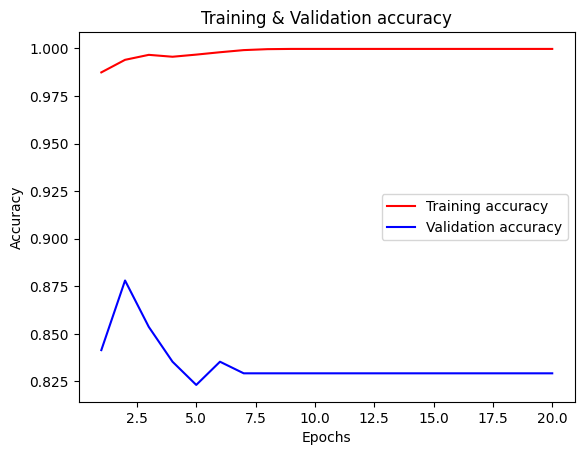

In [50]:
import matplotlib.pyplot as plt

train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = range(1, len(train_acc) + 1)

plt.plot(epochs, train_acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training & Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

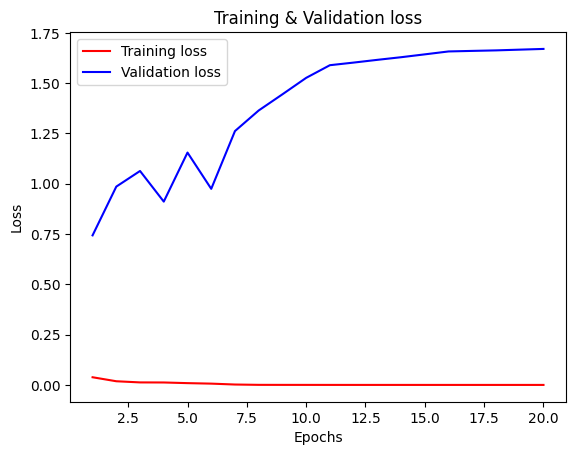

In [51]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(epochs, train_loss, 'r', label="Training loss")
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training & Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [52]:
test_metrics = cnn_lstm_model.evaluate(x_test, y_test_categorical)

test_accuracy = test_metrics[1]
test_loss = test_metrics[0]

print("Test Accuracy :", test_accuracy)
print("Test Accuracy :", test_loss)

65/65 [==============================] - 27s 413ms/step - loss: 1.3938 - accuracy: 0.8468
Test Accuracy : 0.8467544913291931
Test Accuracy : 1.3937748670578003


In [53]:
import numpy as np
from sklearn.metrics import confusion_matrix

# Assuming you have your test data in X_test and your true labels in y_test
# and that your model is already trained and saved as 'model'

# Generate predicted values using the model
y_pred = cnn_lstm_model.predict(x_test)

# Convert predicted values to binary 0/1 predictions
y_pred = np.round(y_pred)

W0000 00:00:1707243435.875306       1 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" model: "0" frequency: 2400 num_cores: 8 environment { key: "cpu_instruction_set" value: "ARM NEON" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 16384 l2_cache_size: 524288 l3_cache_size: 524288 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


65/65 [==============================] - 28s 418ms/step


In [54]:
# Generate confusion matrix
cm=confusion_matrix(y_test_categorical.argmax(axis=1), y_pred.argmax(axis=1))

print(cm)

[[858 167]
 [147 877]]


In [55]:
print(classification_report(y_pred, y_test_categorical))

              precision    recall  f1-score   support

           0       0.84      0.85      0.85      1005
           1       0.86      0.84      0.85      1044

   micro avg       0.85      0.85      0.85      2049
   macro avg       0.85      0.85      0.85      2049
weighted avg       0.85      0.85      0.85      2049
 samples avg       0.85      0.85      0.85      2049



In [39]:
# Define EarlyStopping callback
#early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

cnn_lstm_model.fit(x_train,y_train_categorical, epochs=20, batch_size=64,validation_split=0.2)

Epoch 1/20


W0000 00:00:1701928066.181942       1 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" model: "0" frequency: 2400 num_cores: 8 environment { key: "cpu_instruction_set" value: "ARM NEON" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 16384 l2_cache_size: 524288 l3_cache_size: 524288 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


103/103 [==============================] - ETA: 0s - loss: 0.4409 - accuracy: 0.7873

W0000 00:00:1701928221.326703       1 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" model: "0" frequency: 2400 num_cores: 8 environment { key: "cpu_instruction_set" value: "ARM NEON" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 16384 l2_cache_size: 524288 l3_cache_size: 524288 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


103/103 [==============================] - 171s 2s/step - loss: 0.4409 - accuracy: 0.7873 - val_loss: 0.3712 - val_accuracy: 0.8237
Epoch 2/20
103/103 [==============================] - 166s 2s/step - loss: 0.2273 - accuracy: 0.9034 - val_loss: 0.4121 - val_accuracy: 0.8401
Epoch 3/20
103/103 [==============================] - 168s 2s/step - loss: 0.0809 - accuracy: 0.9712 - val_loss: 0.6906 - val_accuracy: 0.8206
Epoch 4/20
103/103 [==============================] - 167s 2s/step - loss: 0.0362 - accuracy: 0.9887 - val_loss: 0.5293 - val_accuracy: 0.8322
Epoch 5/20
103/103 [==============================] - 184s 2s/step - loss: 0.0248 - accuracy: 0.9905 - val_loss: 0.9133 - val_accuracy: 0.8347
Epoch 6/20
103/103 [==============================] - 159s 2s/step - loss: 0.0093 - accuracy: 0.9973 - val_loss: 0.9353 - val_accuracy: 0.8316
Epoch 7/20
103/103 [==============================] - 168s 2s/step - loss: 0.0058 - accuracy: 0.9982 - val_loss: 0.9402 - val_accuracy: 0.8316
Epoch 8/20

In [40]:
loss, accuracy = cnn_lstm_model.evaluate(x_test, y_test_categorical)


# Print the evaluation results
print(f'Test Loss: {loss:.4f}')
print(f'Test Accuracy: {accuracy*100:.2f}%')

65/65 [==============================] - 20s 314ms/step - loss: 1.7041 - accuracy: 0.8580
Test Loss: 1.7041
Test Accuracy: 85.80%


In [41]:
cnn_lstm_model.save("cnn_lstm.h5")
cnn_lstm_model.save('cnn_lstm.keras')
model_filename = 'cnn_lstm.joblib'
joblib.dump(cnn_lstm_model, model_filename)
print(f"Model saved to {model_filename}")

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model saved to cnn_lstm.joblib


# CNN_GRU

In [56]:
from keras.models import Model
from keras.layers import Input, Embedding, Conv1D, MaxPooling1D, Flatten, Dense, Concatenate, Attention

In [57]:
# Model architecture
input_length = max_length
embedding_dim = 50
num_filters = 150
filter_sizes = [2, 3, 4]
pool_size = 2
dense_units = 100
output_classes = 2  # 2 classes: hate speech and non-hate speech
attention_units = 100
dropout_rate = 0.25

In [58]:
input_layer = Input(shape=(input_length,))

In [59]:
# Embedding layer
embedding_dim = 300  # Set the size of the embedding dimension
embedding_layer = Embedding(vocab_size, 300, input_length=max_length, weights=[embedding_matrix], trainable=True)(input_layer)


In [60]:
# Convolutional layers
conv_layers = []
for filter_size in filter_sizes:
    conv = Conv1D(filters=num_filters, kernel_size=filter_size, activation='relu',padding='same')(embedding_layer)
    pooled = MaxPooling1D(pool_size=pool_size)(conv)
    conv_layers.append(pooled)

In [61]:
merged = Concatenate(axis=-1)(conv_layers)

bidirectional_layer=Bidirectional(GRU(256, return_sequences=True))(merged)

# GRU layer with 128 neurons
gru_layer=GRU(128, return_sequences=True)(bidirectional_layer)

# Word attention layer
attention_layer = Attention()([gru_layer, gru_layer])

flattened_layer = Flatten()(attention_layer)

# Two dense layers with ReLU activation
dense1 = Dense(100, activation='relu')(flattened_layer)
dense2 = Dense(100, activation='relu')(dense1)

# dense2_with_dropout = Dropout(0.25)(dense2)

# Final output layer with softmax activation
output_layer = Dense(2, activation='softmax')(dense2)

# Create the model
cnn_gru_model = Model(inputs=input_layer, outputs=output_layer)

# Compile the model
cnn_gru_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display the model summary
cnn_gru_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 292)]                0         []                            
                                                                                                  
 embedding_4 (Embedding)     (None, 292, 300)             6746100   ['input_3[0][0]']             
                                                                                                  
 conv1d_3 (Conv1D)           (None, 292, 150)             90150     ['embedding_4[0][0]']         
                                                                                                  
 conv1d_4 (Conv1D)           (None, 292, 150)             135150    ['embedding_4[0][0]']         
                                                                                            

In [62]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler, ReduceLROnPlateau, TerminateOnNaN

callback_list = [
                 ModelCheckpoint(
                     filepath = './best_CNN_GRUmodel.hdf5',
                     monitor = 'val_accuracy',
                     verbose = 1,
                     save_best_only = True,
                     save_weights_only = False,
                     mode = 'max',
                     period = 1
                 ),

                 EarlyStopping(
                    monitor = 'val_accuracy',
                    patience = 20,
                    verbose = 1,
                    mode = 'max',
                    baseline = 0.5,
                    restore_best_weights = True
                 ),

                 ReduceLROnPlateau(
                     monitor = 'val_loss',
                     factor = 0.2,
                     patience = 5,
                     verbose = 1,
                     mode = 'min',
                     cooldown = 1,
                     min_lr = 0
                 ),

                 TerminateOnNaN()
]



In [63]:
history = cnn_gru_model.fit(x_train,y_train_categorical, epochs=20, batch_size=64,verbose = 1,callbacks = callback_list,validation_split = 0.02,shuffle = True)

Epoch 1/20


W0000 00:00:1707243586.893275       1 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" model: "0" frequency: 2400 num_cores: 8 environment { key: "cpu_instruction_set" value: "ARM NEON" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 16384 l2_cache_size: 524288 l3_cache_size: 524288 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


126/126 [==============================] - ETA: 0s - loss: 0.4127 - accuracy: 0.8052

W0000 00:00:1707243789.956311       1 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" model: "0" frequency: 2400 num_cores: 8 environment { key: "cpu_instruction_set" value: "ARM NEON" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 16384 l2_cache_size: 524288 l3_cache_size: 524288 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }



Epoch 1: val_accuracy improved from -inf to 0.79878, saving model to ./best_CNN_GRUmodel.hdf5


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


126/126 [==============================] - 208s 2s/step - loss: 0.4127 - accuracy: 0.8052 - val_loss: 0.3702 - val_accuracy: 0.7988 - lr: 0.0010
Epoch 2/20
126/126 [==============================] - ETA: 0s - loss: 0.2171 - accuracy: 0.9124
Epoch 2: val_accuracy improved from 0.79878 to 0.80488, saving model to ./best_CNN_GRUmodel.hdf5
126/126 [==============================] - 197s 2s/step - loss: 0.2171 - accuracy: 0.9124 - val_loss: 0.4896 - val_accuracy: 0.8049 - lr: 0.0010
Epoch 3/20
126/126 [==============================] - ETA: 0s - loss: 0.0883 - accuracy: 0.9690
Epoch 3: val_accuracy improved from 0.80488 to 0.85976, saving model to ./best_CNN_GRUmodel.hdf5
126/126 [==============================] - 197s 2s/step - loss: 0.0883 - accuracy: 0.9690 - val_loss: 0.4291 - val_accuracy: 0.8598 - lr: 0.0010
Epoch 4/20
126/126 [==============================] - ETA: 0s - loss: 0.0389 - accuracy: 0.9880
Epoch 4: val_accuracy did not improve from 0.85976
126/126 [=======================

In [64]:
print("Best Validation Accuracy =", max(history.history['val_accuracy'])*100)
print("Best Training Accuracy =", max(history.history['accuracy'])*100)

Best Validation Accuracy = 85.97561120986938
Best Training Accuracy = 99.97509121894836


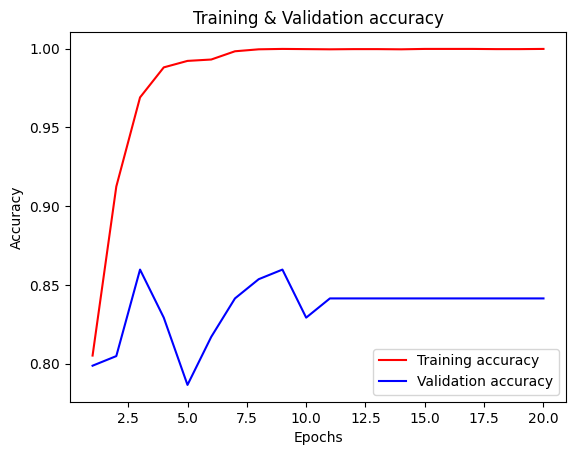

In [65]:
import matplotlib.pyplot as plt

train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = range(1, len(train_acc) + 1)

plt.plot(epochs, train_acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training & Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

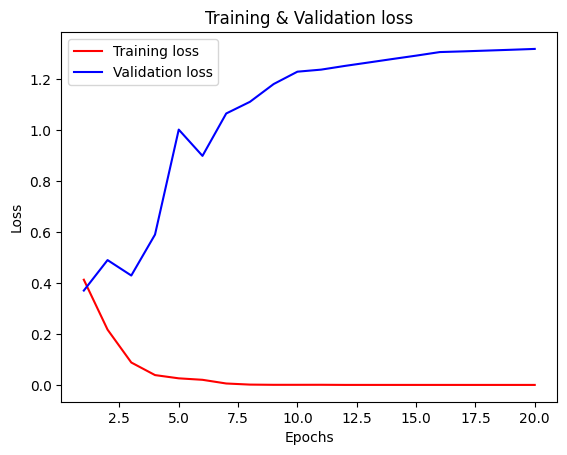

In [66]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(epochs, train_loss, 'r', label="Training loss")
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training & Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


In [67]:
test_metrics = cnn_gru_model.evaluate(x_test, y_test_categorical)




test_accuracy = test_metrics[1]
test_loss = test_metrics[0]

print("Test Accuracy :", test_accuracy)
print("Test Accuracy :", test_loss)



65/65 [==============================] - 20s 306ms/step - loss: 0.9797 - accuracy: 0.8565
Test Accuracy : 0.8565153479576111
Test Accuracy : 0.9797279238700867


In [68]:
import numpy as np
from sklearn.metrics import confusion_matrix

# Assuming you have your test data in X_test and your true labels in y_test
# and that your model is already trained and saved as 'model'

# Generate predicted values using the model
y_pred = cnn_gru_model.predict(x_test)

# Convert predicted values to binary 0/1 predictions
y_pred = np.round(y_pred)

W0000 00:00:1707247498.264971       1 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" model: "0" frequency: 2400 num_cores: 8 environment { key: "cpu_instruction_set" value: "ARM NEON" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 16384 l2_cache_size: 524288 l3_cache_size: 524288 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


65/65 [==============================] - 21s 307ms/step


In [69]:
# Generate confusion matrix
cm=confusion_matrix(y_test_categorical.argmax(axis=1), y_pred.argmax(axis=1))

print(cm)


[[881 144]
 [150 874]]


In [70]:


print(classification_report(y_pred, y_test_categorical))



              precision    recall  f1-score   support

           0       0.86      0.85      0.86      1031
           1       0.85      0.86      0.86      1018

   micro avg       0.86      0.86      0.86      2049
   macro avg       0.86      0.86      0.86      2049
weighted avg       0.86      0.86      0.86      2049
 samples avg       0.86      0.86      0.86      2049



In [51]:

cnn_gru_model.fit(x_train,y_train_categorical, epochs=20, batch_size=64,validation_split=0.2)

Epoch 1/20


W0000 00:00:1701936466.001836       1 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" model: "0" frequency: 2400 num_cores: 8 environment { key: "cpu_instruction_set" value: "ARM NEON" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 16384 l2_cache_size: 524288 l3_cache_size: 524288 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


103/103 [==============================] - ETA: 0s - loss: 0.4343 - accuracy: 0.7756

W0000 00:00:1701936600.515551       1 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" model: "0" frequency: 2400 num_cores: 8 environment { key: "cpu_instruction_set" value: "ARM NEON" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 16384 l2_cache_size: 524288 l3_cache_size: 524288 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


103/103 [==============================] - 147s 1s/step - loss: 0.4343 - accuracy: 0.7756 - val_loss: 0.3947 - val_accuracy: 0.8298
Epoch 2/20
103/103 [==============================] - 140s 1s/step - loss: 0.2436 - accuracy: 0.8972 - val_loss: 0.3956 - val_accuracy: 0.8316
Epoch 3/20
103/103 [==============================] - 140s 1s/step - loss: 0.1019 - accuracy: 0.9616 - val_loss: 0.5646 - val_accuracy: 0.8414
Epoch 4/20
103/103 [==============================] - 152s 1s/step - loss: 0.0420 - accuracy: 0.9861 - val_loss: 0.7565 - val_accuracy: 0.8310
Epoch 5/20
103/103 [==============================] - 255s 2s/step - loss: 0.0231 - accuracy: 0.9927 - val_loss: 0.7240 - val_accuracy: 0.8481
Epoch 6/20
103/103 [==============================] - 153s 1s/step - loss: 0.0170 - accuracy: 0.9945 - val_loss: 0.9754 - val_accuracy: 0.8334
Epoch 7/20
103/103 [==============================] - 140s 1s/step - loss: 0.0075 - accuracy: 0.9977 - val_loss: 1.2012 - val_accuracy: 0.8395
Epoch 8/20

In [52]:
loss, accuracy = cnn_gru_model.evaluate(x_test, y_test_categorical)


# Print the evaluation results
print(f'Test Loss: {loss:.4f}')
print(f'Test Accuracy: {accuracy*100:.2f}%')

65/65 [==============================] - 26s 407ms/step - loss: 1.1556 - accuracy: 0.8536
Test Loss: 1.1556
Test Accuracy: 85.36%


In [53]:
cnn_gru_model.save("cnn_gru.h5")
cnn_gru_model.save('cnn_gru.keras')
model_filename = 'cnn_gru.joblib'
joblib.dump(cnn_gru_model, model_filename)
print(f"Model saved to {model_filename}")

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model saved to cnn_gru.joblib


# Load the model

In [13]:
cnnmodel = joblib.load('cnn.joblib')
loss, accuracy = cnnmodel.evaluate(x_test, y_test_categorical)


# Print the evaluation results
print(f'Test Loss: {loss:.4f}')
print(f'Test Accuracy: {accuracy*100:.2f}%')

65/65 [==============================] - 6s 97ms/step - loss: 0.4673 - accuracy: 0.9492
Test Loss: 0.4673
Test Accuracy: 94.92%


# Ensemble model

In [84]:
cnnmodel = joblib.load('cnn.joblib')
#grumodel = joblib.load('gru.joblib')
lstmmodel = joblib.load('lstm.joblib')
cnn_lstm_model = joblib.load('cnn_lstm.joblib')
cnn_gru_model = joblib.load('cnn_gru.joblib')

In [44]:
from keras.layers import Input, Average
from keras.models import Model

In [45]:
from keras.models import load_model
cnn = load_model('best_CNN_GRUmodel.hdf5')

In [76]:
loss, accuracy = cnn.evaluate(x_test, y_test_categorical)


W0000 00:00:1707248011.180033       1 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" model: "0" frequency: 2400 num_cores: 8 environment { key: "cpu_instruction_set" value: "ARM NEON" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 16384 l2_cache_size: 524288 l3_cache_size: 524288 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


65/65 [==============================] - 22s 323ms/step - loss: 0.3913 - accuracy: 0.8609


In [77]:
# Print the evaluation results
print(f'Test Loss: {loss:.4f}')
print(f'Test Accuracy: {accuracy*100:.2f}%')

Test Loss: 0.3913
Test Accuracy: 86.09%


In [48]:
from keras.models import load_model
cnn = load_model('best_CNNmodel.hdf5')
gru = load_model('best_GRUmodel.hdf5',custom_objects={'AttentionLayer':AttentionLayer})
lstm = load_model('best_LSTMmodel.hdf5')
cnn_lstm = load_model('best_CNN_LSTMmodel.hdf5')
cnn_gru = load_model('best_CNN_GRUmodel.hdf5')

In [110]:
input_layer = Input(shape=(max_length,))

cnn_output = cnn(input_layer)
gru_output = grumodel(input_layer)
lstm_output = lstm(input_layer)
cnn_lstm_output = cnn_lstm(input_layer)
cnn_gru_output = cnn_gru(input_layer)

# Use layers.average to compute the average of the models' outputs
ensemble_output = Average()([cnn_output, gru_output, lstm_output, cnn_lstm_output, cnn_gru_output])

# Create the ensemble model
ensemble_model = Model(inputs=input_layer, outputs=ensemble_output)

# Compile the ensemble model (you may need to adjust the optimizer, loss, and metrics)
ensemble_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

# Display the ensemble model summary
ensemble_model.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_12 (InputLayer)       [(None, 292)]                0         []                            
                                                                                                  
 model_7 (Functional)        (None, 2)                    1373195   ['input_12[0][0]']            
                                                          3                                       
                                                                                                  
 sequential_1 (Sequential)   (None, 2)                    1162331   ['input_12[0][0]']            
                                                          8                                       
                                                                                            

In [111]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler, ReduceLROnPlateau, TerminateOnNaN

callback_list = [
                 ModelCheckpoint(
                     filepath = './best_Ensemblemodel.hdf5',
                     monitor = 'val_accuracy',
                     verbose = 1,
                     save_best_only = True,
                     save_weights_only = False,
                     mode = 'max',
                     period = 1
                 ),

                 EarlyStopping(
                    monitor = 'val_accuracy',
                    patience = 20,
                    verbose = 1,
                    mode = 'max',
                    baseline = 0.5,
                    restore_best_weights = True
                 ),

                 ReduceLROnPlateau(
                     monitor = 'val_loss',
                     factor = 0.2,
                     patience = 5,
                     verbose = 1,
                     mode = 'min',
                     cooldown = 1,
                     min_lr = 0
                 ),

                 TerminateOnNaN()
]









In [112]:
history = ensemble_model.fit(x_train,y_train_categorical, epochs=20, batch_size=64,verbose = 1,callbacks = callback_list,validation_split = 0.02,shuffle = True)

Epoch 1/20


W0000 00:00:1707265260.536614       1 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" model: "0" frequency: 2400 num_cores: 8 environment { key: "cpu_instruction_set" value: "ARM NEON" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 16384 l2_cache_size: 524288 l3_cache_size: 524288 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }
W0000 00:00:1707265260.539466       1 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" model: "0" frequency: 2400 num_cores: 8 environment { key: "cpu_instruction_set" value: "ARM NEON" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 16384 l2_cache_size: 524288 l3_cache_size: 524288 memory_size: 26843

126/126 [==============================] - ETA: 0s - loss: 0.0054 - accuracy: 0.9985  

W0000 00:00:1707274349.409845       1 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" model: "0" frequency: 2400 num_cores: 8 environment { key: "cpu_instruction_set" value: "ARM NEON" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 16384 l2_cache_size: 524288 l3_cache_size: 524288 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }
W0000 00:00:1707274349.411140       1 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" model: "0" frequency: 2400 num_cores: 8 environment { key: "cpu_instruction_set" value: "ARM NEON" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 16384 l2_cache_size: 524288 l3_cache_size: 524288 memory_size: 26843


Epoch 1: val_accuracy improved from -inf to 0.83537, saving model to ./best_Ensemblemodel.hdf5


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


126/126 [==============================] - 9106s 73s/step - loss: 0.0054 - accuracy: 0.9985 - val_loss: 0.1247 - val_accuracy: 0.8354 - lr: 0.0010
Epoch 2/20
126/126 [==============================] - ETA: 0s - loss: 0.0042 - accuracy: 0.9984
Epoch 2: val_accuracy did not improve from 0.83537
126/126 [==============================] - 907s 7s/step - loss: 0.0042 - accuracy: 0.9984 - val_loss: 0.1505 - val_accuracy: 0.8049 - lr: 0.0010
Epoch 3/20
126/126 [==============================] - ETA: 0s - loss: 0.0057 - accuracy: 0.9976  
Epoch 3: val_accuracy improved from 0.83537 to 0.84756, saving model to ./best_Ensemblemodel.hdf5
126/126 [==============================] - 11197s 90s/step - loss: 0.0057 - accuracy: 0.9976 - val_loss: 0.1273 - val_accuracy: 0.8476 - lr: 0.0010
Epoch 4/20
126/126 [==============================] - ETA: 0s - loss: 0.0657 - accuracy: 0.9884
Epoch 4: val_accuracy did not improve from 0.84756
126/126 [==============================] - 865s 7s/step - loss: 0.0657

In [ ]:

ensemble_model.fit(x_train,y_train_categorical, epochs=20, batch_size=64,validation_split=0.2)

In [113]:
print("Best Validation Accuracy =", max(history.history['val_accuracy'])*100)
print("Best Training Accuracy =", max(history.history['accuracy'])*100)


Best Validation Accuracy = 84.75610017776489
Best Training Accuracy = 99.90035891532898


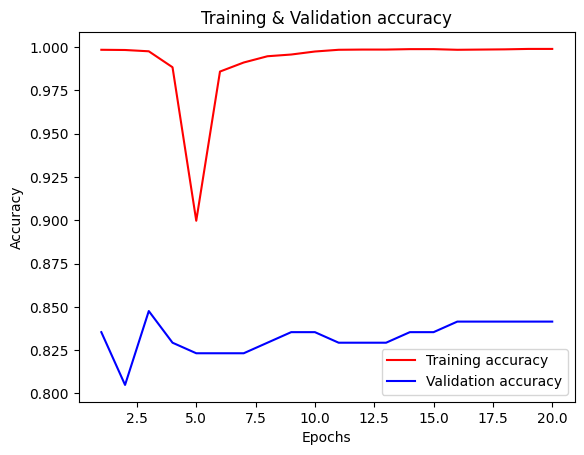

In [114]:
import matplotlib.pyplot as plt

train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = range(1, len(train_acc) + 1)

plt.plot(epochs, train_acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training & Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


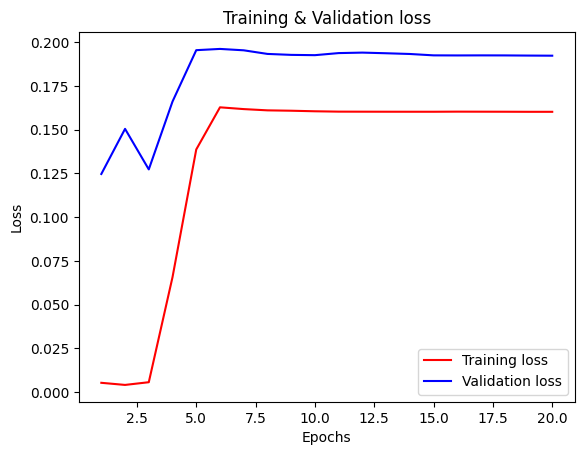

In [115]:


train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(epochs, train_loss, 'r', label="Training loss")
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training & Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()



In [116]:
test_metrics = ensemble_model.evaluate(x_test, y_test_categorical)


65/65 [==============================] - 98s 2s/step - loss: 0.1901 - accuracy: 0.8492


In [117]:
test_accuracy = test_metrics[1]
test_loss = test_metrics[0]

print("Test Accuracy :", test_accuracy)
print("Test Accuracy :", test_loss)

Test Accuracy : 0.8491947054862976
Test Accuracy : 0.19011190533638


In [118]:
import numpy as np
from sklearn.metrics import confusion_matrix

# Assuming you have your test data in X_test and your true labels in y_test
# and that your model is already trained and saved as 'model'

# Generate predicted values using the model
y_pred = ensemble_model.predict(x_test)

# Convert predicted values to binary 0/1 predictions
y_pred = np.round(y_pred)


W0000 00:00:1707316957.530614       1 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" model: "0" frequency: 2400 num_cores: 8 environment { key: "cpu_instruction_set" value: "ARM NEON" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 16384 l2_cache_size: 524288 l3_cache_size: 524288 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }
W0000 00:00:1707316957.532219       1 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" model: "0" frequency: 2400 num_cores: 8 environment { key: "cpu_instruction_set" value: "ARM NEON" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 16384 l2_cache_size: 524288 l3_cache_size: 524288 memory_size: 26843

65/65 [==============================] - 79s 1s/step


In [119]:
# Generate confusion matrix
cm=confusion_matrix(y_test_categorical.argmax(axis=1), y_pred.argmax(axis=1))

print(cm)

[[859 166]
 [143 881]]


In [120]:
print(classification_report(y_pred, y_test_categorical))

              precision    recall  f1-score   support

           0       0.84      0.86      0.85      1002
           1       0.86      0.84      0.85      1047

   micro avg       0.85      0.85      0.85      2049
   macro avg       0.85      0.85      0.85      2049
weighted avg       0.85      0.85      0.85      2049
 samples avg       0.85      0.85      0.85      2049



# Explainable AI

In [20]:
import tensorflow as tf
from lime.lime_text import LimeTextExplainer


In [50]:
from keras.models import load_model
ensemble_model = load_model('/Users/bablo/Desktop/Project/Final/best_Ensemblemodel.hdf5',custom_objects={'AttentionLayer':AttentionLayer})

In [23]:
# Sample text for LIME analysis
sample_text = "Gandhi said RSS is the biggest threat to India, still is"

In [127]:
s_text="about genocides msm response to the video of white women being decapitated by muslim terrorists silence a white terrorist killing muslims outrage bcs white supremacy is the worst danger facts more than 70 of attacks victims of terrorism are at the hands of islamist terroristsy"

In [53]:
p_text="happy holidays to everyone from the summit business technologies team may 2019 be your best year yet"

In [25]:
from keras.preprocessing.text import Tokenizer
t=Tokenizer()

In [26]:
def pre(text):

    sample_sequence = t.texts_to_sequences(text)
    padded_sequence = pad_sequences(sample_sequence, maxlen=max_length,padding="post")
    y=ensemble_model.predict(padded_sequence)
    return y

In [51]:
class_names = ['negative', 'positive']
explainer = LimeTextExplainer(class_names=class_names)
exp = explainer.explain_instance(sample_text,pre)

W0000 00:00:1707625524.098888       1 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" model: "0" frequency: 2400 num_cores: 8 environment { key: "cpu_instruction_set" value: "ARM NEON" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 16384 l2_cache_size: 524288 l3_cache_size: 524288 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }
W0000 00:00:1707625524.100272       1 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" model: "0" frequency: 2400 num_cores: 8 environment { key: "cpu_instruction_set" value: "ARM NEON" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 16384 l2_cache_size: 524288 l3_cache_size: 524288 memory_size: 26843

157/157 [==============================] - 207s 1s/step


In [135]:
p_exp = explainer.explain_instance(p_text,pre)

157/157 [==============================] - 200s 1s/step


In [54]:
p_exp = explainer.explain_instance(p_text,pre)

157/157 [==============================] - 208s 1s/step


In [129]:
exp.show_in_notebook(text=True)

In [136]:
p_exp.show_in_notebook(text=True)

In [64]:
loss, accuracy = ensemble_model.evaluate(x_test, y_test_categorical)


# Print the evaluation results
print(f'Test Loss: {loss:.4f}')
print(f'Test Accuracy: {accuracy*100:.2f}%')

65/65 [==============================] - 76s 1s/step - loss: 0.1132 - accuracy: 0.8453
Test Loss: 0.1132
Test Accuracy: 84.53%


[0.831, 0.841, 0.839, 0.836, 0.834, 0.831, 0.834, 0.834, 0.834, 0.834, 0.834, 0.834, 0.846, 0.835, 0.834, 0.833, 0.834, 0.833, 0.833, 0.832]


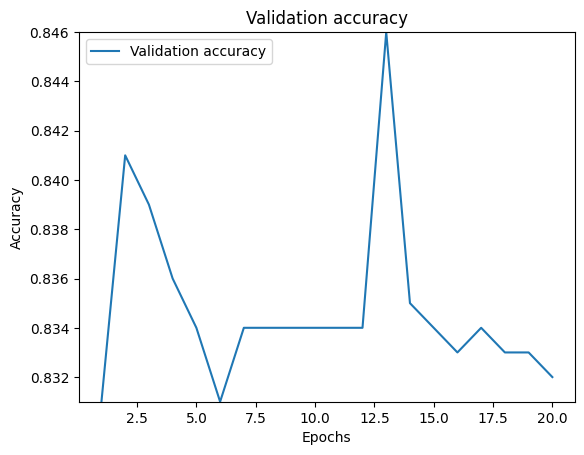

In [113]:
import matplotlib.pyplot as plt

train_acc = "0.831 0.841 0.839 0.836 0.834 0.831 0.834 0.834 0.834 0.834 0.834 0.834 0.846 0.835 0.834 0.833 0.834 0.833 0.833 0.832"
acc=train_acc.split(" ")
acc = list(map(float, acc))
print(acc)


epochs = range(1, len(acc) + 1)
plt.ylim([min(acc), max(acc)])
plt.plot(epochs, acc,label='Validation accuracy')

plt.title('Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

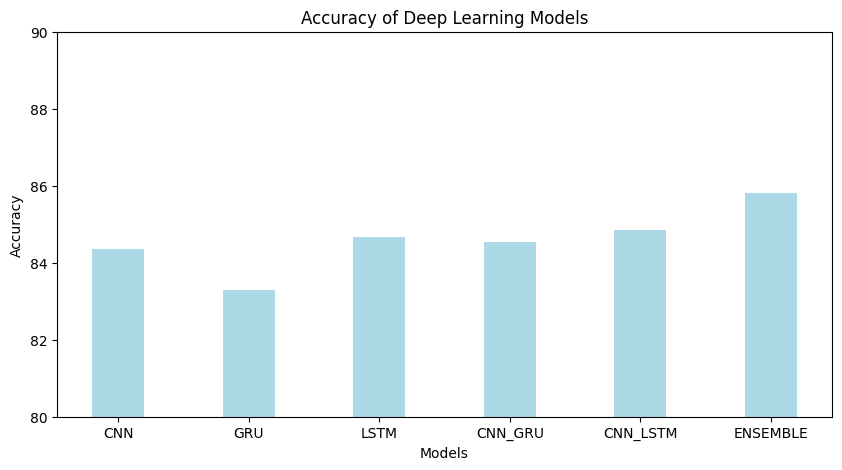

In [122]:
import numpy as np
import matplotlib.pyplot as plt 
 
  
# creating the dataset
data = {'CNN':84.36, 'GRU':83.29, 'LSTM':84.66,'CNN_GRU':84.53, 
        'CNN_LSTM':84.86,'ENSEMBLE':85.80}
courses = list(data.keys())
values = list(data.values())
  
fig = plt.figure(figsize = (10, 5))
plt.ylim(80,90)
# creating the bar plot
plt.bar(courses, values, color ='lightblue', 
        width = 0.4)
 
plt.xlabel("Models")
plt.ylabel("Accuracy")
plt.title("Accuracy of Deep Learning Models")
plt.show()